# Multiple comparisons

In [1]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'grid.linestyle':'--'})

## Data generation

In [2]:
import numpy as np
np.random.seed(10)

n_samples = 10000
Y = np.random.random(n_samples)

In [3]:
import pandas as pd

n_trials = 500
X = []
for _ in range(n_trials):
    X.append(np.random.randint(2, size=n_samples))

data = pd.DataFrame(np.array(X).T)
data.rename(columns={c: f'x_{c}' for c in data.columns}, inplace=True)
data['y'] = Y

pd.set_option('max_columns', 10)
data.head()

,x_0,x_1,x_2,x_3,x_4,...,x_496,x_497,x_498,x_499,y
0,1,1,0,0,1,...,1,1,0,0,0.771321
1,0,0,1,0,1,...,1,0,0,0,0.020752
2,0,0,0,0,1,...,1,0,1,0,0.633648
3,1,1,1,1,0,...,0,1,0,1,0.748804
4,1,1,0,0,1,...,1,0,0,1,0.498507


## Multiple comparisons with all Nulls being true

In [4]:
# conduct multiple comparisons
from tqdm import tqdm
from typing import List
from scipy import stats

def multiple_comparisons(data: pd.DataFrame, label='y') -> List[float]:
    """Run multiple t tests."""
    p_values = []
    for c in tqdm(data.columns):
        if c.startswith('y'): 
            continue
        group_a = data[data[c] == 0][label]
        group_b = data[data[c] == 1][label]

        _, p = stats.ttest_ind(group_a, group_b, equal_var=True)
        p_values.append((c, p))
    
    return p_values

p_values = multiple_comparisons(data)

100%|██████████| 501/501 [00:17<00:00, 29.28it/s]


<IPython.core.display.Javascript object>


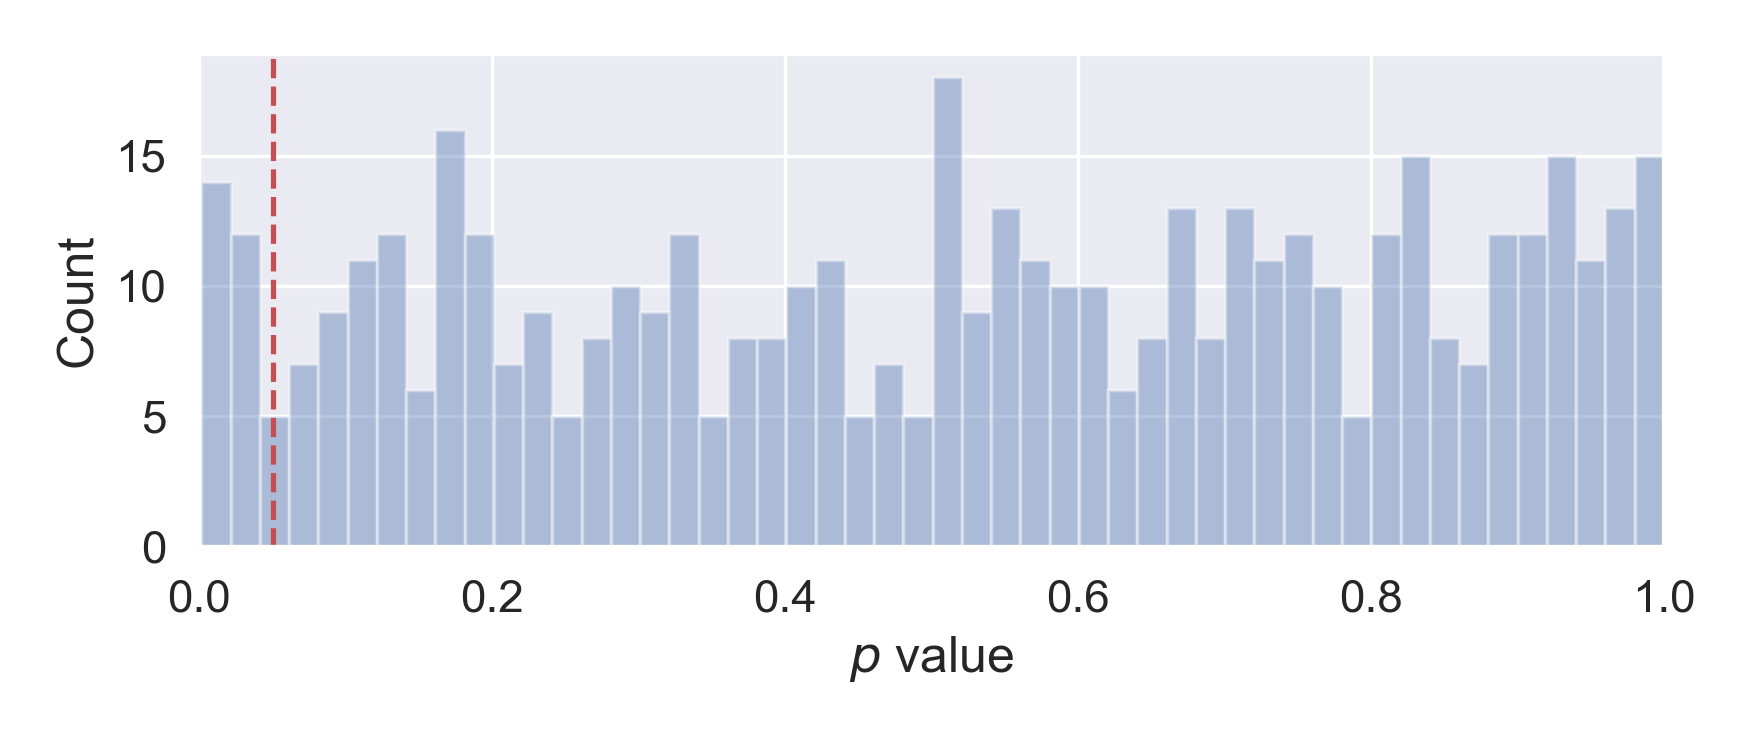

In [5]:
threshold = 0.05
def plot_p_values(p_values, threshold=0.05):
    """Plot the histogram of p values."""
    sns.set(font_scale=1.2)
    plt.figure(figsize=(7, 3))
    sns.distplot([x[1] for x in p_values], kde=False, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--')
    
    plt.xlim([0, 1])
    plt.xlabel('$\it{p}$ value')
    plt.ylabel('Count')
    plt.tight_layout()
    
plot_p_values(p_values, threshold=threshold)

In [6]:
# summary
print('Total number of discoveries is: {:,}'
      .format(sum([x[1] < threshold for x in p_values])))
print('Percentage of significant results: {:5.2%}'
      .format(sum([x[1] < threshold for x in p_values]) / n_trials))

Total number of discoveries is: 27
Percentage of significant results: 5.40%


In [7]:
# bonferroni correction
print('Total number of discoveries is: {:,}'
      .format(sum([x[1] < threshold / n_trials for x in p_values])))
print('Percentage of significant results: {:5.2%}'
      .format(sum([x[1] < threshold / n_trials for x in p_values]) / n_trials))

Total number of discoveries is: 0
Percentage of significant results: 0.00%


## Multiple comparisons with half of Nulls being false

In [8]:
# add true signals
n_true_features = n_trials // 2

offset = np.random.normal(loc=1., size=(n_samples, n_true_features))        
offset_sum = np.multiply(
    offset, 
    data[data.columns[:n_true_features]].values).sum(axis=1)
Y2 = Y + offset_sum

data['y2'] = Y2

100%|██████████| 502/502 [00:11<00:00, 43.52it/s]


<IPython.core.display.Javascript object>


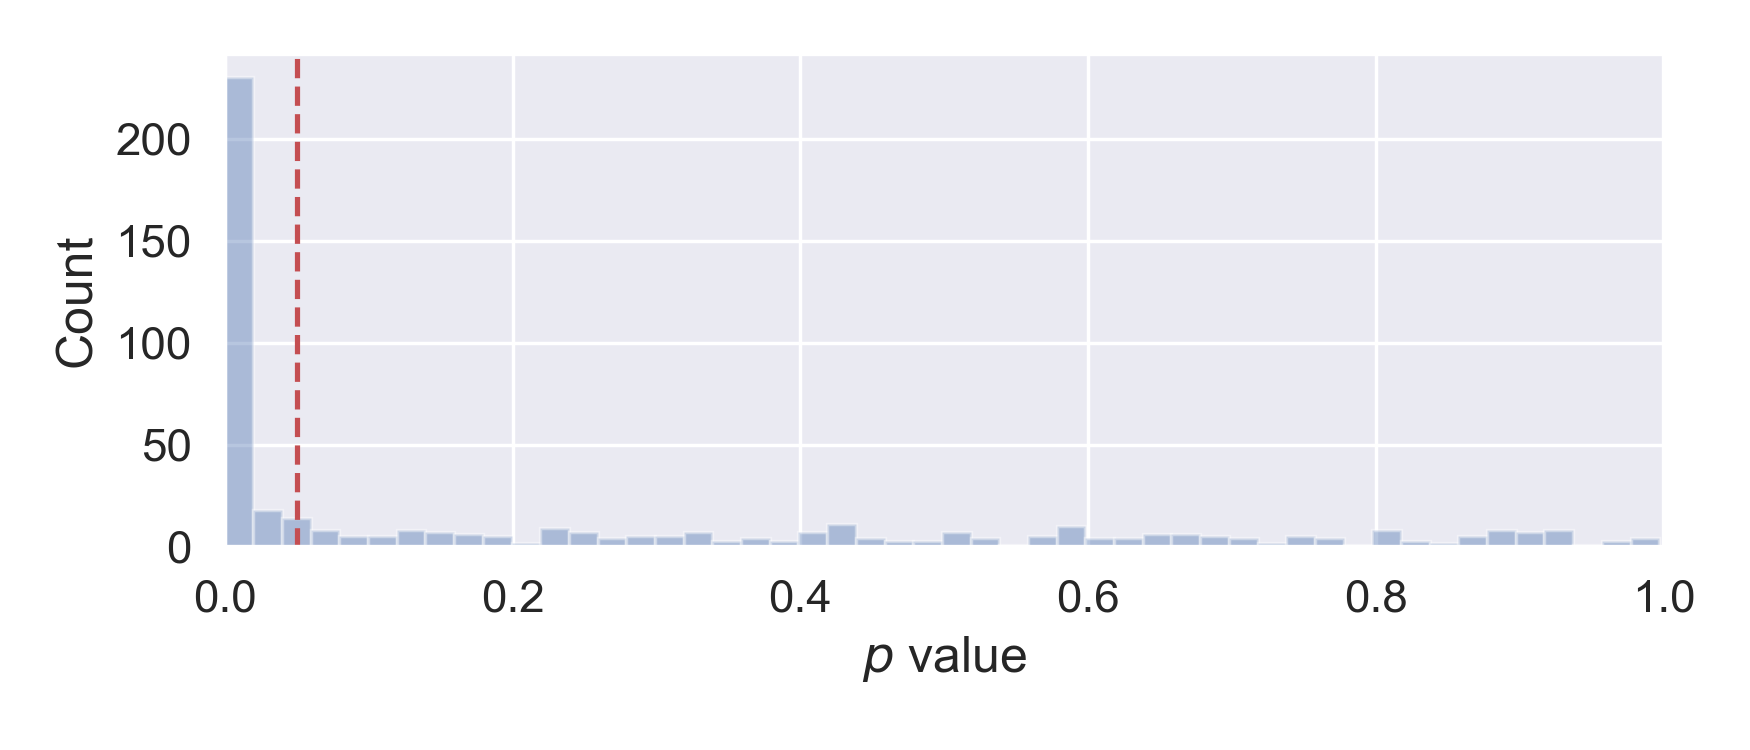

In [9]:
p_values = multiple_comparisons(data, label='y2')
plot_p_values(p_values, threshold=threshold)

In [10]:
# summary
print('Total number of discoveries is: {:,}'
      .format(sum([x[1] < threshold for x in p_values])))
print('Percentage of significant results: {:5.2%}'
      .format(sum([x[1] < threshold for x in p_values]) / n_trials))

Total number of discoveries is: 257
Percentage of significant results: 51.40%


In [11]:
# bonferroni correction
print('Total number of discoveries is: {:,}'
      .format(sum([x[1] < threshold / n_trials for x in p_values])))
print('Percentage of significant results: {:5.2%}'
      .format(sum([x[1] < threshold / n_trials for x in p_values]) / n_trials))

# for c, p in p_values:
#     if p < threshold / n_trials:
#         print(c)

Total number of discoveries is: 99
Percentage of significant results: 19.80%


In [12]:
# Benjamini–Hochberg procedure
p_values.sort(key=lambda x: x[1])

for i, x in enumerate(p_values):
    if x[1] >= (i + 1) / len(p_values) * threshold:
        break
significant = p_values[:i]

print('Total number of discoveries is: {:,}'
      .format(len(significant)))
print('Percentage of significant results: {:5.2%}'
      .format(len(significant) / n_trials))

Total number of discoveries is: 235
Percentage of significant results: 47.00%


<IPython.core.display.Javascript object>


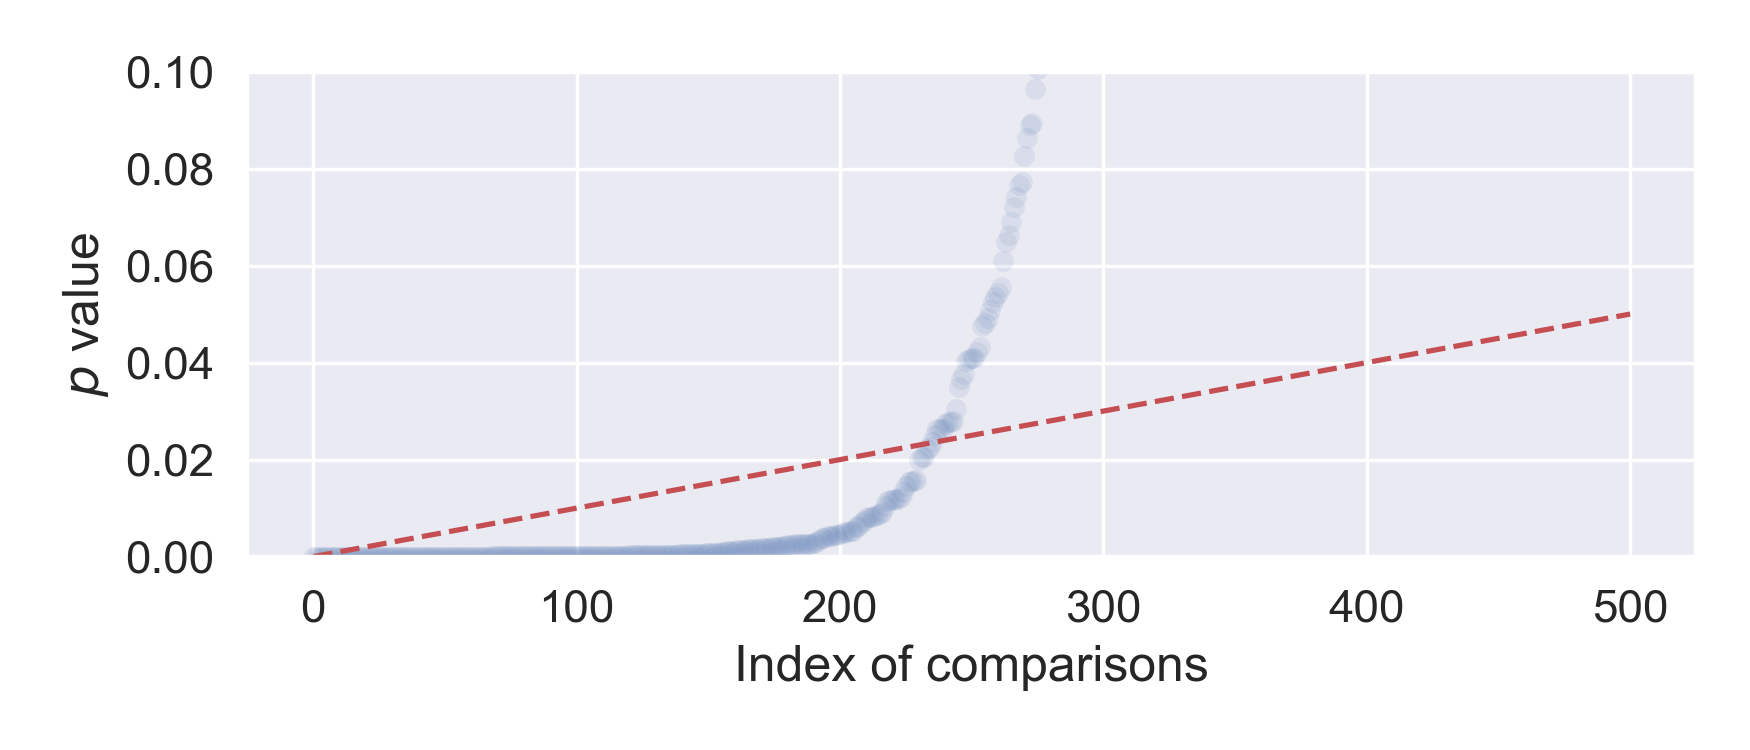

In [13]:
plt.figure(figsize=(7, 3))
sns.scatterplot(
    x=range(len(p_values)), y=[x[1] for x in p_values],
    alpha=0.1, linewidth=0)
plt.plot([0, len(p_values)], [0, threshold], 'r--')
plt.ylim(0, 2 * threshold)
plt.xlabel('Index of comparisons')
plt.ylabel('$\it{p}$ value')
plt.tight_layout()

In [14]:
# false positives from BH
FP = []
for x in sorted(significant):
    if int(x[0][2:]) >= n_trials // 2:
        FP.append(x)
print('Number of False Positives:', len(FP))

Number of False Positives: 9


In [15]:
# false positives from BH
found = set()
for x in sorted(significant):
    if int(x[0][2:]) < n_trials // 2:
        found.add(int(x[0][2:]))
print('Number of False Negatives:', len(set(range(250)).difference(found)))

Number of False Negatives: 24


## Calculate FN without any correction

In [16]:
std = np.sqrt(0.75 * 250 + 1 / 12)
s = std * np.sqrt(2 / (n_samples / 2))
print('The sample variance is: ', std)
t_stats = -1 / s
print('The test statistic is: ', t_stats)

The sample variance is:  13.696106502701172
The test statistic is:  -3.6506725462553105


In [17]:
data['y2'].std()

13.729757361537473

In [18]:
FN = 250 * stats.norm().cdf(t_stats + 1.96)
print('Number of False Negatives: ', FN)

Number of False Negatives:  11.362420063347814
